In [136]:
import os
import pyspark
import kagglehub
import json
import us
import probablepeople as pp
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [137]:
# Initiate Spark Session
spark = SparkSession.builder.appName("example").getOrCreate()

# 1. Load Dataset from Kaggle

In [138]:
# Download latest version
path = kagglehub.dataset_download("jinquan/cc-sample-data")

In [139]:
# Load dataset
raw_df = spark.read.json(path)

In [140]:
# Check dtypes
raw_df.printSchema()

# NOTE: Currently 15 columns with one nested column, the expected columns have 26 columns

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



# 2. Flatten JSON
- recursively flatten the nested json

In [141]:
# Function to dynamically infer the schema, parse JSON and flatten the cols 
def infer_and_parse_json(df, json_string_col, prefix: bool = False):
    # Step 1: Retrieve a sample of the JSON data - sample using first row to save compute
    sample_json = df.select(json_string_col).limit(1).collect()[0][0]
    
    # Step 2: Parse the JSON string into a dictionary
    parsed_json = json.loads(sample_json)
    
    # Step 3: Dynamically create the schema based on the JSON keys
    # All fields will be treated as StringType for now
    schema = StructType([StructField(key, StringType(), True) for key in parsed_json.keys()])
    
    # Step 4: Apply from_json to parse the column using the inferred schema
    df = df.withColumn(f"{json_string_col}_struct", from_json(col(json_string_col), schema))
    
    # Step 5: Flatten the struct into individual columns
    for field in schema.fields:
        if prefix:
            df = df.withColumn(f"{json_string_col}_{field.name}", col(f"{json_string_col}_struct.{field.name}"))
        else:
            df = df.withColumn(f"{field.name}", col(f"{json_string_col}_struct.{field.name}"))

    # Drop the original json string column and the intermediate struct column
    df = df.drop(json_string_col, f"{json_string_col}_struct")
    
    return df

# Flatten first json string col - personal_details
stg_df = infer_and_parse_json(df=raw_df, json_string_col="personal_detail", prefix=False)
# Flatten second/nested json string col - address in personal_details
stg_df = infer_and_parse_json(df=stg_df, json_string_col="address", prefix=False)
stg_df.show(truncate=False)

+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+----------------------------------------+---------------------+--------------------------------+-------------------------+------+-------+------------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat         |merch_long        |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |person_name              |gender|lat    |long              |city_pop|job                                          |dob       |street                        |city                    |state|zip  |
+----------+------+-------------+-----------+-------------------+--------+------------

In [142]:
print(f"Number of columns for stg_df: {len(stg_df.columns)}")
# NOTE: This is 25/27 expected columns where it is missing "first" and "last" column (name)

Number of columns for stg_df: 25


# 3. Name Derivations - Clean Names
- clean and split names from "person_name" and "merchant" accordingly

In [143]:
# Function to split the name column by all special characters - create first and last name columns
def split_person_name(df):
    # Split person_name by any non-alphanumeric character (special characters)
    # NOTE: this way, consecutive delimiters like "," will be considered as one, and will not take empty string as last name for example
    split_col = split(col("person_name"), "[^a-zA-Z0-9]+")
    
    # Create new columns "first" and "last" from the split, with trimming and capitalization
    df = df.withColumn("first", initcap(trim(split_col.getItem(0)))) \
           .withColumn("last", initcap(trim(split_col.getItem(1))))
    
    return df

# Apply the function to your DataFrame
stg_df = split_person_name(stg_df).drop("person_name")

# Show the resulting DataFrame
stg_df.show(truncate=False)

+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+----------------------------------------+---------------------+--------------------------------+------+-------+------------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+-----------+---------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat         |merch_long        |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |gender|lat    |long              |city_pop|job                                          |dob       |street                        |city                    |state|zip  |first      |last     |
+----------+------+-------------+-----------+-------------------+--------+----------------+---

In [144]:
# Clean up "merchant" name
# Check if the all the values have "fraud_" prefix 
stg_df.withColumn("merchant_clean", substring(col("merchant"), 1, 5)).groupBy("merchant_clean").count().show()
# NOTE: Yes all records have "fraud" prefix

# Clean up the merchant column
stg_df = stg_df.withColumn("merchant", split(col("merchant"), "fraud_").getItem(1))

+--------------+-------+
|merchant_clean|  count|
+--------------+-------+
|         fraud|1296675|
+--------------+-------+



# 4. Data Quality Assurance
1. Check for Duplicates:
    - Ensure that there are no repeated records in the dataset that could lead to skewed analysis or double counting.
    - Finding: No duplicated rows

2. Completeness:
    - Verify that all required fields and values are present and no critical data is missing (i.e. missing/null values or empty strings)
    - Finding: merch_zipcode has 195973 null values and cc_bic has 144381 records with empty strings

3. Accuracy:
    - Confirm that the data correctly represents real-world values and events without errors or inconsistencies.
    - Findings:
        - Numerical columns like "amt" and "city_pop" should not have negative values - PASSED
        - Boolean columns like "is_fraud" should have 0 or 1 values only - PASSED
        - Columns with standardized code like "state" should have only specific number of chars - PASSED: All values are 2 characters and checked against the directory for the states in the US.
        - Name columns like "first" and "last" name columns should consist actual names and not test datas - PASSED: All values are checked against NLP (probablepeople) for entity recognition
        - Categorical columns like "category" should have proper categories: PASSED

4. Timeliness:
    - Ensure that the data is up to date and available within the expected time frame for its intended use.
        - Findings: All datetime columns are loaded as string and parsing datetime string to datetime columns does not return error (and with proper date ranges)- PASSED

5. Schema Validation:
    - Check that the structure of the data (e.g., data types, field names, required columns) matches the defined schema or data model.
        - Transformation done: Defined all new schema and apply to the dataset

## Check for Duplicates

In [145]:
# Data Quality Check - Check for Duplicates
# Return records with duplicate values across all columns
stg_df.exceptAll(stg_df.dropDuplicates()).show()
# NOTE: Passed - 0 duplicate records

25/05/16 01:38:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/16 01:38:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/16 01:38:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/16 01:38:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/16 01:38:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/16 01:38:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/16 01:38:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/16 01:38:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/16 01:38:30 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+



## Completeness

In [146]:
stg_df.filter(col("merchant").isNull()).show()

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+



In [147]:
# Data Quality Check - Completeness
# Check completeness: Count null values in each column
stg_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in stg_df.columns)).show()

# NOTE: "merch_zipcode" has nulls

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|         0|  0|       0|     0|     0|       0|             0|                     0|        0|         0|       195973|       0|                    0|        0|     0|  0|   0|       0|  0|  0|     0|   0|    0|  0|    0|   0|
+----------+---+--------+------+------+--------+--------------+---------------------

In [148]:
# Data Quality Check - Completeness
# Check completeness: Count columns with empty string values in each column
stg_df.select(*(sum((col(c)=="").cast("int")).alias(c) for c in stg_df.columns)).show()

# NOTE: "cc_bic" has empty strings

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|         0|  0|       0|144381|     0|       0|             0|                     0|        0|         0|            0|       0|                    0|        0|     0|  0|   0|       0|  0|  0|     0|   0|    0|  0|    0|   0|
+----------+---+--------+------+------+--------+--------------+---------------------

## Accuracy

In [149]:
# For numerical columns - check there's no negative values
for c in ["amt", "city_pop"]:
    null_or_negative_counts = stg_df.filter(col(c).cast("int") <= 0).count()
    if null_or_negative_counts > 0:
        print(f"The column {c} has {null_or_negative_counts} records")
    else:
        print(f"The column '{c}' has no null or negative records - PASSED")

The column 'amt' has no null or negative records - PASSED


The column 'city_pop' has no null or negative records - PASSED


In [150]:
# Check for boolean column - "is_fraud" to have 0 and 1 value only
stg_df.select("is_fraud").distinct().show()

# NOTE: PASSED - only 0 and 1

+--------+
|is_fraud|
+--------+
|       0|
|       1|
+--------+



In [151]:
# Check for zipcode to have only 5 characters only
stg_df.filter(col("merch_zipcode").isNotNull()).withColumn(
    "merch_zipcode_count", length("merch_zipcode")
).groupBy("merch_zipcode_count").count().show()
# NOTE: PASSED - non-null values only have 5 chars

+-------------------+-------+
|merch_zipcode_count|  count|
+-------------------+-------+
|                  5|1100702|
+-------------------+-------+



In [152]:
# Check for state code to have only 2 characters only
stg_df.filter(col("state").isNotNull()).withColumn(
    "state_count", length("state")
).groupBy("state_count").count().show()
# NOTE: PASSED - non-null values only have 2 chars

+-----------+-------+
|state_count|  count|
+-----------+-------+
|          2|1296675|
+-----------+-------+



In [153]:
# Use python library "us" to check if the state codes are legit
states_list = [str(state_code) for state_code in stg_df.select("state").distinct().collect()]
illegible_state_codes = [us.states.lookup(state_code) for state_code in states_list if us.states.lookup(state_code)]
illegible_state_codes
# NOTE: PASSED - All state codes are legit

[]

In [154]:
## Check if first names are legit US names using Python Library/NLP - probablepeople
def label_names(text: str):
    # Label using the probablepeople library - returns the tab either Person or Corporation
    return pp.tag(text)[-1]

udf_label_names = udf(lambda x: label_names(x), returnType=StringType())

agg_first_names = stg_df.groupBy("first").count().sort(desc("count")).withColumn("label", udf_label_names(col("first")))
agg_first_names.show()

agg_first_names.filter(col("label")!= "Person").show()

# NOTE: PASSED - All first names are proper US-names

+-----------+-----+------+
|      first|count| label|
+-----------+-----+------+
|Christopher|26669|Person|
|     Robert|21667|Person|
|    Jessica|20581|Person|
|      James|20039|Person|
|    Michael|20009|Person|
|      David|19965|Person|
|   Jennifer|16940|Person|
|    William|16371|Person|
|       Mary|16346|Person|
|       John|16325|Person|
|   Margaret|15312|Person|
|     Joseph|14792|Person|
|     Daniel|13867|Person|
|       Lisa|13767|Person|
|     Amanda|13310|Person|
|     Ashley|13296|Person|
|    Jeffrey|12831|Person|
|   Michelle|12601|Person|
|     Samuel|12179|Person|
|   Kimberly|11815|Person|
+-----------+-----+------+
only showing top 20 rows



+-----+-----+-----+
|first|count|label|
+-----+-----+-----+
+-----+-----+-----+



In [155]:
## Check if last names are legit US names using Python Library/NLP - probablepeople
agg_last_names = stg_df.groupBy("last").count().sort(desc("count")).withColumn("label", udf_label_names(col("last")))
agg_last_names.show()

agg_last_names.filter(col("label")!= "Person").show()

+---------+-----+------+
|     last|count| label|
+---------+-----+------+
|    Smith|28794|Person|
| Williams|23605|Person|
|    Davis|21910|Person|
|  Johnson|20034|Person|
|Rodriguez|17394|Person|
| Martinez|14805|Person|
|    Jones|13976|Person|
|    Lewis|12753|Person|
| Gonzalez|11799|Person|
|   Miller|11698|Person|
|     Lowe|11308|Person|
|   Martin|11252|Person|
|     Bell|10784|Person|
|    Perez| 9729|Person|
| Robinson| 9287|Person|
|   Bishop| 9254|Person|
|   Garcia| 9186|Person|
|  Mendoza| 8763|Person|
|   Thomas| 8724|Person|
|    Clark| 8715|Person|
+---------+-----+------+
only showing top 20 rows



+----+-----+-----+
|last|count|label|
+----+-----+-----+
+----+-----+-----+



In [156]:
# Check if categorical column - category is proper
stg_df.groupBy("category").count().show()

# NOTE: Passed

+--------------+------+
|      category| count|
+--------------+------+
|        travel| 40507|
|      misc_net| 63287|
|   grocery_pos|123638|
|     kids_pets|113035|
|  shopping_net| 97543|
|   grocery_net| 45452|
|   food_dining| 91461|
| gas_transport|131659|
| personal_care| 90758|
|health_fitness| 85879|
| entertainment| 94014|
|          home|123115|
|      misc_pos| 79655|
|  shopping_pos|116672|
+--------------+------+



In [157]:
# Check if categorical column - job is proper
stg_df.groupBy("job").count().sort(desc("count")).show()
# NOTE: Passed

+--------------------+-----+
|                 job|count|
+--------------------+-----+
|   Film/video editor| 9779|
| Exhibition designer| 9199|
|     Naval architect| 8684|
|Surveyor, land/ge...| 8680|
|  Materials engineer| 8270|
|Designer, ceramic...| 8225|
|   Systems developer| 7700|
|          IT trainer| 7679|
|   Financial adviser| 7659|
|Environmental con...| 7547|
|Chartered public ...| 7210|
|Scientist, audiol...| 7174|
|Chief Executive O...| 7172|
|Copywriter, adver...| 7146|
|         Comptroller| 6730|
|                 Sub| 6701|
|          Podiatrist| 6653|
|Agricultural cons...| 6642|
|           Paramedic| 6635|
|Magazine features...| 6602|
+--------------------+-----+
only showing top 20 rows



## Timeliness


## Parse Datetime

In [158]:
# Parse datetime string to datetime cols - including dob to be date col
datetime_cols = ["merch_eff_time", "trans_date_trans_time", "merch_last_update_time"]

stg_df = stg_df.withColumns(
    {
        colname: from_utc_timestamp(
            to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss"),
            "Asia/Singapore",
        )
        for colname in datetime_cols
    }
).withColumn("dob", to_date(col("dob"), "yyyy-MM-dd")) # Parse DOB to date

In [159]:
# Check the date range for all datetime columns
for c in [*datetime_cols, "dob"]:
    print(f"The date range for column '{c}' is {stg_df.select(min(c)).collect()[0][0].strftime("%Y-%m-%d")} to {stg_df.select(max(c)).collect()[0][0].strftime("%Y-%m-%d")}")


# NOTE: The date range seems normal for datetime cols - PASSED

The date range for column 'merch_eff_time' is 2019-01-01 to 2020-06-21


The date range for column 'trans_date_trans_time' is 2019-01-01 to 2020-06-21
The date range for column 'merch_last_update_time' is 2019-01-01 to 2020-06-21


The date range for column 'dob' is 1924-10-30 to 2005-01-29


## Schema validation 
- Convert columns to appropriate dtypes

In [160]:
stg_df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: timestamp (nullable = true)
 |-- merch_last_update_time: timestamp (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- first: string (nullable

In [161]:
stg_df.show()

+----------+------+-------------+-----------+-------------------+--------+-------------------+----------------------+------------------+------------------+-------------+--------------------+---------------------+--------------------+------+-------+------------------+--------+--------------------+----------+--------------------+--------------------+-----+-----+-----------+---------+
|Unnamed: 0|   amt|     category|     cc_bic|             cc_num|is_fraud|     merch_eff_time|merch_last_update_time|         merch_lat|        merch_long|merch_zipcode|            merchant|trans_date_trans_time|           trans_num|gender|    lat|              long|city_pop|                 job|       dob|              street|                city|state|  zip|      first|     last|
+----------+------+-------------+-----------+-------------------+--------+-------------------+----------------------+------------------+------------------+-------------+--------------------+---------------------+------------------

In [162]:
new_schema = StructType(
    [
        StructField("Unnamed: 0", StringType(), True),
        StructField("amt", StringType(), True),
        StructField("category", StringType(), True),
        StructField("cc_bic", StringType(), True),
        StructField("cc_num", StringType(), True),
        StructField("is_fraud", StringType(), True),
        StructField("merch_eff_time", TimestampType(), True),
        StructField("merch_last_update_time", TimestampType(), True),
        StructField("merch_lat", StringType(), True),
        StructField("merch_long", StringType(), True),
        StructField("merch_zipcode", StringType(), True),
        StructField("merchant", StringType(), True),
        StructField("trans_date_trans_time", TimestampType(), True),
        StructField("trans_num", StringType(), True),
        StructField("gender", StringType(), True),
        StructField("lat", StringType(), True),
        StructField("long", StringType(), True),
        StructField("city_pop", StringType(), True),
        StructField("job", StringType(), True),
        StructField("dob", DateType(), True),
        StructField("street", StringType(), True),
        StructField("city", StringType(), True),
        StructField("state", StringType(), True),
        StructField("zip", StringType(), True),
        StructField("first", StringType(), True),
        StructField("last", StringType(), True),
    ]
)
stg_df = spark.createDataFrame(stg_df.rdd, schema=new_schema)

In [163]:
stg_df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: timestamp (nullable = true)
 |-- merch_last_update_time: timestamp (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- first: string (nullable

# 5. Descriptive Statistics

In [ ]:
def describe_columns(df: DataFrame, high_card_threshold=0.5):
    total_rows = df.count()
    summary = []

    for column in df.columns:
        # Null values
        null_count = df.filter(col(column).isNull()).count()
        null_pct = (null_count / total_rows) * 100

        # Empty string values
        empty_string_count = df.filter(
            (col(column) == "") & (col(column).isNotNull())
        ).count()
        empty_string_pct = (empty_string_count / total_rows) * 100

        # Distinct count
        distinct_count = df.select(column).distinct().count()

        # Non Null values
        non_null_values = df.filter(col(column).isNotNull()).count()

        # High cardinality
        high_card = distinct_count > (non_null_values * high_card_threshold)

        summary.append(
            {
                "column_name": column,
                "distinct_values": distinct_count,
                "null_values": null_count,
                "empty_string_values": empty_string_count,
                "high_cardinality": high_card,
                "null %": null_pct,
                "empty strings %": empty_string_pct,
            }
        )

    return spark.createDataFrame(summary).select(
        "column_name",
        "distinct_values",
        "null_values",
        "empty_string_values",
        "high_cardinality",
        round("null %", 2).alias("null %"),
        round("empty strings %", 2).alias("null %"),
    )

In [177]:
describe_columns(stg_df.select("merch_zipcode", "cc_bic")).show(truncate=False)

+-------------+---------------+-----------+-------------------+----------------+------+------+
|column_name  |distinct_values|null_values|empty_string_values|high_cardinality|null %|null %|
+-------------+---------------+-----------+-------------------+----------------+------+------+
|merch_zipcode|28337          |195973     |0                  |false           |15.11 |0.0   |
|cc_bic       |9              |0          |144381             |false           |0.0   |11.13 |
+-------------+---------------+-----------+-------------------+----------------+------+------+



Findings 
- While merch_zipcode and cc_bic have <20% empty strings & null % combined - these features can still be used 
- Note that high cardinality = when distinct value is > 50% of non-null records of the column

# 6. Handling PII Data
- Instead of using AES encryption that is more safe but is not friendly for analytics, for this exercise purpose, we will use SHA-256 hashing with salt. 
- While hashing is irreversible - we can store another table that can be access when absolutely necessary (e.g. compliance)

Actions Taken / Created PII Columns
- person_id - Hashed First + Last + DOB as person identifier
- cc_num - Hashed cc_num for credit card details (cannot combine with cc_bic as there are missing values that may affect the EDA later)

In [178]:
# Create a unique hash ID using SHA-256 + added salt (random word) - Person name
dim_df =  stg_df.withColumn(
    "person_id",
    sha2(
        concat(lit("securedPII:"), concat_ws(":", "first", "last", "dob")),
        256
    )
)
# Create a unique hash ID using SHA-256 + added salt (random word) - Credit card number
dim_df =  dim_df.withColumn(
    "cc_id",
    sha2(
        concat(lit("securedPII:"), col("cc_num")),
        256
    )
)

# Store as separated tables for future references
pii_person_id_df = dim_df.select("person_id", "first", "last", "dob").dropDuplicates()

# Store as separated tables for future references
pii_cc_id_df = dim_df.select("cc_id", "cc_num").dropDuplicates()

# Drop the PII columns
dim_df = dim_df.drop("first", "last", "cc_num")


In [179]:
# PII info like person_name and cc_num has been dropped 
dim_df.show()

+----------+------+-------------+-----------+--------+-------------------+----------------------+------------------+------------------+-------------+--------------------+---------------------+--------------------+------+-------+------------------+--------+--------------------+----------+--------------------+--------------------+-----+-----+--------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|is_fraud|     merch_eff_time|merch_last_update_time|         merch_lat|        merch_long|merch_zipcode|            merchant|trans_date_trans_time|           trans_num|gender|    lat|              long|city_pop|                 job|       dob|              street|                city|state|  zip|           person_id|               cc_id|
+----------+------+-------------+-----------+--------+-------------------+----------------------+------------------+------------------+-------------+--------------------+---------------------+--------------------+------+-------+--

# 7. Exploratory Data Analysis

In [180]:
dim_df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: timestamp (nullable = true)
 |-- merch_last_update_time: timestamp (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- person_id: string (nullable = true)
 |-- cc_id: string (nulla

In [200]:
data.sort_values("amt")

,amt,city_pop,is_fraud
34740,1.0,5950,0
1121732,1.0,19054,0
111039,1.0,1139,0
1121560,1.0,139,0
921797,1.0,238602,0
...,...,...,...
469047,999.7,1263321,0
744910,999.76,601723,1
229799,999.84,191096,1
457440,9995.78,237282,0


/home/kennysim/anaconda3/envs/kennysim/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


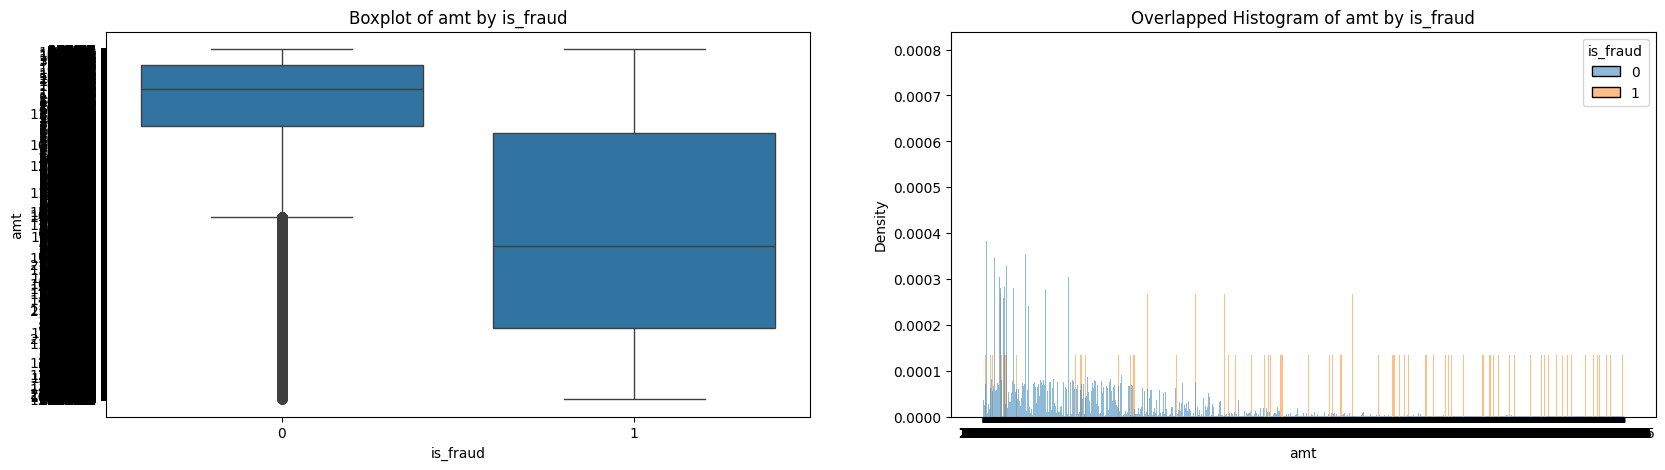

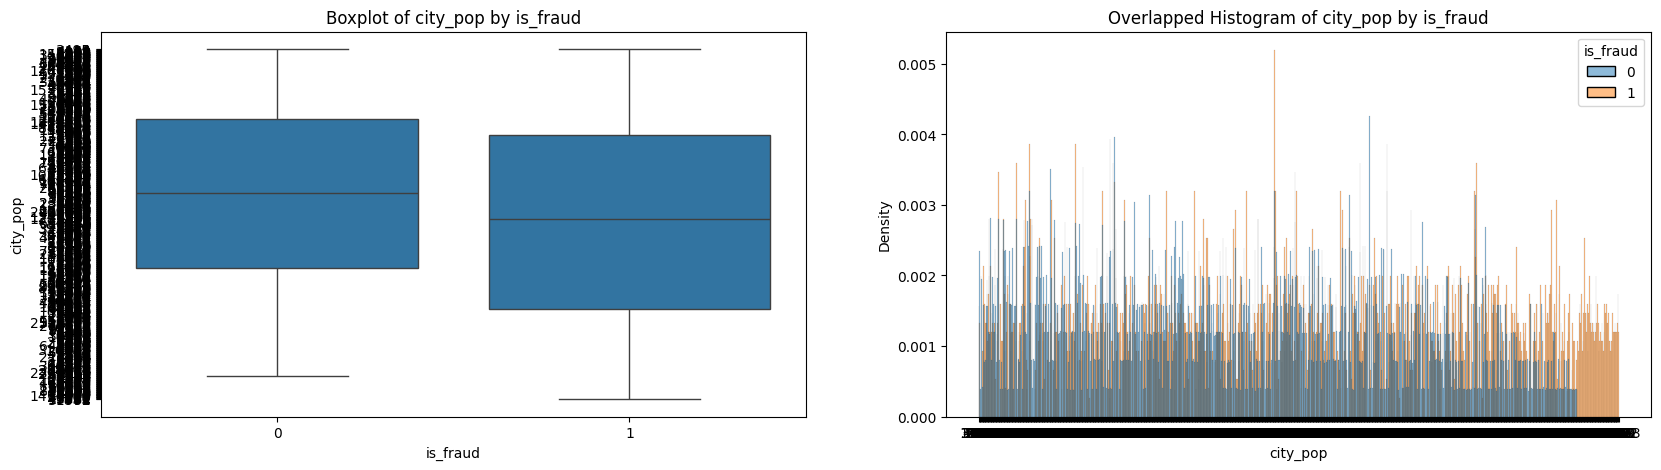

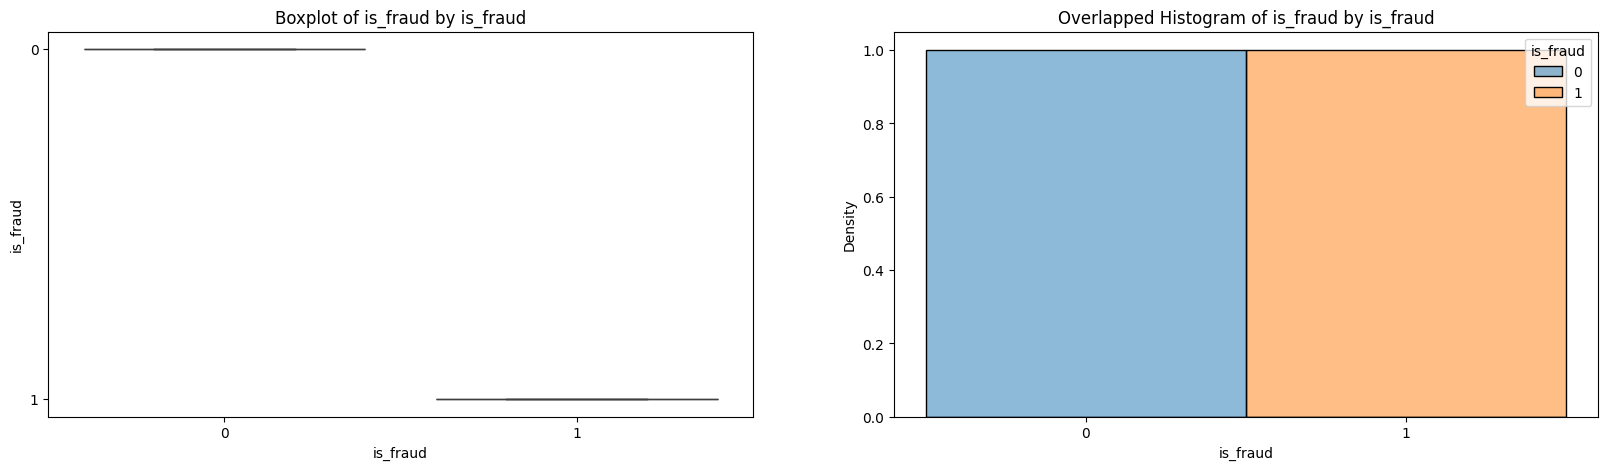

In [198]:
numerical_cols = ["amt", "city_pop", "is_fraud"]
data = dim_df.select(numerical_cols).toPandas()

for feature in numerical_cols:
    plt.figure(figsize=(20, 5))

    # First subplot for the boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=data, x="is_fraud", y=feature)
    plt.title(f"Boxplot of {feature} by is_fraud")

    # Second subplot for the histogram
    plt.subplot(1,2,2)
    sns.histplot(data=data, x=feature, hue="is_fraud", stat="density", common_norm=False)
    plt.title(f"Overlapped Histogram of {feature} by is_fraud")

    plt.show()

Observation: 
- Seems like the density of transactions that are fraudulent happens to higher value transactions and also to places where the city population is higher

## Check if One Person Has Multiple Credit Cards
- Suspicious if a person has many cards not consistent with typical behavior

In [ ]:
# Check for 
agg_person = dim_df.groupby("person_id").agg(
    countDistinct("cc_id").alias("count_distinct_cc_id"), 
    count("cc_id").alias("count_cc_id_transaction")
).sort(desc("count_distinct_cc_id"))
agg_person.show()

+--------------------+--------------------+-----------------------+
|           person_id|count_distinct_cc_id|count_cc_id_transaction|
+--------------------+--------------------+-----------------------+
|cfa9abd07cf19e70d...|                   1|                   1037|
|48fb31df56031112a...|                   1|                   2063|
|68b434b6aafb5e3aa...|                   1|                    510|
|9a22fe262004bc3a4...|                   1|                   1535|
|f2ba11a6cb8ddcb62...|                   1|                   1029|
|7d27fa98a77a33eff...|                   1|                     11|
|135e75523242811f1...|                   1|                      7|
|8bcaf4967ff4e466c...|                   1|                    520|
|56c922d5d55d91ddb...|                   1|                   1530|
|9cc5746b8e72ded02...|                   1|                    516|
|e53e21dc51d096aa4...|                   1|                   1046|
|88cdfd82aff23bb95...|                   1|     

# Check if One Credit Card Used by Multiple Persons
- Could indicate stolen or shared card

In [201]:
agg_cc_id = dim_df.groupby("cc_id").agg(
    countDistinct("person_id").alias("count_distinct_person_id"), 
    count("person_id").alias("count_person_id_transaction")
).sort(desc("count_distinct_person_id"))
agg_cc_id.show()

+--------------------+------------------------+---------------------------+
|               cc_id|count_distinct_person_id|count_person_id_transaction|
+--------------------+------------------------+---------------------------+
|65a4b6b9981529af1...|                       1|                        504|
|cc0cb46fe1dfcf015...|                       1|                       2082|
|1a4efe66e90a855f7...|                       1|                       2523|
|c0f13035aa4e69e93...|                       1|                       2572|
|65e35541e7862a61e...|                       1|                       1523|
|ca841600a2d4d90b9...|                       1|                        511|
|de192b163372e341a...|                       1|                       1022|
|606d0d82d018b23c7...|                       1|                       1538|
|eebfe7692ce9dac4e...|                       1|                       3119|
|7dbe5ab7dad497d8b...|                       1|                       1577|
|5110e3f6573